In [1]:
### Importing required libraries

## 데이터 전처리 시 사용
from time import time
import sqlite3
import pandas as pd
import numpy as np

## 데이터 시각화 시 사용
import seaborn as sns
import matplotlib.pyplot as plt

## 학습용 데이터 분배
from sklearn.model_selection import train_test_split
from sklearn import model_selection    # 교차검증 시

## 모델링 시 사용
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
# from sklearn.ensemble import GradientBoostingClassifier

## 손실 함수에서 scorer 만들기
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score #, classification_report
from sklearn.decomposition import PCA # , FastICA

# Grid Search 시 같이 사용되었던 함수, 정확한 쓰임새는 모름
from sklearn.pipeline import Pipeline

# CalibratedClassifierCV: isotonic 회귀 또는 로지스틱 회귀를 사용한 확률 보정
from sklearn.calibration import CalibratedClassifierCV

# confusion matrix(그래프) 생성 시 사용
from sklearn.metrics import confusion_matrix
import itertools # 그래프 작성 시 반복 작업
from sklearn.metrics import classification_report  # 주요 분류 측정항목을 보여주는 텍스트 보고서 작성


# 

# from sklearn.decomposition import FastICA
# 


import warnings

warnings.simplefilter("ignore")

In [2]:
start = time()

## Fetching data???
# DB 연결
path = "../input/soccer/"   # Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

# 그리드 서치 중 병렬로 실행할 작업 수 정의 (하이퍼파라미터 조정 시 설정해야할 조건 중 하나인 듯)
n_jobs = 1

# 데이터 테이블 가져오기
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

In [3]:
# 동일 데이터 삭제 (런타임 요구 사항 충족을 위함)
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", 
        "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal", 
        "home_player_1", "home_player_2", "home_player_3", "home_player_4", 
        "home_player_5", "home_player_6", "home_player_7", "home_player_8", 
        "home_player_9", "home_player_10", "home_player_11", "away_player_1", 
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", 
       "away_player_6", "away_player_7", "away_player_8", "away_player_9", "away_player_10",
       "away_player_11"]
match_data.dropna(subset = rows, inplace = True)    # 결측값이 들어있는 행 전체 제거
match_data = match_data.tail(1500)    # 데이터 확인 시 주로 사용되는 함수(tail())

In [4]:
def get_fifa_stats(match, player_stats):
    
    '''주어진 경기의 FIFA 스텟 집계'''
    
    # 변수 선언
    match_id = match.match_api_id
    date = match['date']
    players = ["home_player_1", "home_player_2", "home_player_3", "home_player_4", 
        "home_player_5", "home_player_6", "home_player_7", "home_player_8", 
        "home_player_9", "home_player_10", "home_player_11", "away_player_1", 
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", 
       "away_player_6", "away_player_7", "away_player_8", "away_player_9", "away_player_10",
       "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    # 모든 선수들을 loop
    for player in players:
        
        # Get player ID
        player_id = match[player]
        
        # Get player stats
        stats = player_stats[player_stats.player_api_id == player_id]
        
        # 현재 스탯 식별
        # ascending=False: 내림차순 정렬
        # [:1]의 의미는 뭐지?
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending=False)[:1]
#         if(player=="home_player_1"):
#             print(current_stats)
        
        # isnan: 데이터가 nan(not a number)인지 아닌지 판별해주는 함수. nan이면 True, nan이 아니면 False
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            
            # 전처리 과정에 의해 뒤죽박죽된 index 재배열
            # drop=True: 기존 인덱스 버리고 재배열
            # inplace=True: 새로운 변수에 넣지 않고 바로 바꾸기
            current_stats.reset_index(inplace=True, drop=True)
            
            # current_stats의 0번째 열만 조회하여 Series 객체 생성(?)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])
#             print(overall_rating)
            
        # Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
        
        # Aggregate stats
        # pd.concat: 여러 개의 Dataframe 합치기
        # axis=1: 연결할 축(columns)
        # 계속해서 각 경기별 각 팀의 선수들 overall이 저장됨
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis=1)
    
    player_stats_new.columns = names
    player_stats_new['match_api_id'] = match_id    # 열 추가
    player_stats_new.reset_index(inplace=True, drop=True)    # 전처리 과정에 의해 뒤죽박죽된 index 재배열
    
    #Return player stats
    return player_stats_new.loc[0]


def get_fifa_data(matches, player_stats, path=None, data_exists=False):
    
    '''모든 경기의 fifa 데이터 가져오기'''
    
    # fifa 데이터가 이미 존재하는지 체크
    if data_exists == True:
        fifa_data = pd.read_pickle(path)    # pickled pandas 객체를 파일에서 load
    else:
        print("각 경기마다 fifa 데이터 모으는 중...")
        start = time()
        
        # get_fifa_stats를 각 경기마다 적용
        # apply(): Dataframe의 축을 따라 함수 적용
        # axis=1: 각 행마다 함수 적용
        # 각 경기의 FIFA 스탯(오버롤) 정리하기
        fifa_data = matches.apply(lambda x : get_fifa_stats(x, player_stats), axis=1)
        
        end = time()
        print("FIFA 데이터가 {:.1f}분 안에 모였습니다.".format((end - start)/60))
        
    # return fifa_data 
    
    return fifa_data

In [5]:
## feature 생성, 데이터 탐색 및 모델 학습을 위한 데이터 세팅

# 우리가 가진 FIFA 데이터 생성, 검색
# 각 경기별 선수들 overall 가져오기
fifa_data = get_fifa_data(match_data, player_stats_data, data_exists = False)

각 경기마다 fifa 데이터 모으는 중...
FIFA 데이터가 1.4분 안에 모였습니다.


In [6]:
def get_overall_fifa_rankings(fifa, get_overall=False):
    
    ''' FIFA 데이터로부터 오버롤 FIFA 랭킹 가져오기 '''
    
    temp_data = fifa
#     print(temp_data)
    # 플레이어의 오버롤 통계만 원하는지 확인
    if get_overall == True:
        
        # 오버롤 스탯 가져오기
        data = temp_data.loc[:, (fifa.columns.str.contains('overall_rating'))]
        data.loc[:, 'match_api_id'] = temp_data.loc[:, 'match_api_id']
#         print(data)
    
    else:
        
        # stat date를 제외한 모든 스탯 가져오기
        cols = fifa.loc[:, (fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis=1)
        data = temp_data
        
    # Return data
    return data
    
    
def get_last_matches(matches, date, team, x=10):
    
    ''' 주어진 팀의 이전 x경기 가져오기 '''
    
    # matches에서 특정 팀의 경기만 걸러내기
    # |: or 연산자(정확히 뭔지는 모르겠음)
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
    
    # 위에서 걸러낸 경기 중 이전 x 경기만 걸러내기
    last_matches = team_matches[team_matches.date < date].sort_values(by='date', ascending=False).iloc[0:x,:]
    
    # Return last matches
    return last_matches


def get_last_matches_against_eachother(matches, date, home_team, away_team, x=10):
    
    ''' 주어진 두 팀 간의 최근 x 경기 가져오기 '''
    
    # 두 팀 간의 경기 찾기
    # 홈-어웨이 바뀐 경기까지 고려
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]
    total_matches = pd.concat([home_matches, away_matches])    # 합치기
    
    # 이전 x 경기 가져오기
    # 정렬을 위한 코드
    # 0:x까지 행 가져오기
    try:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending=False).iloc[0:x, :]
    except:    # 총 경기 수가 x개 미만인 경우
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending=False).iloc[0:total_matches.shape[0], :]
        
        # Check for error in data
        # 무슨 에러땜에 추가한 걸까?
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
    
    # Return data
    return last_matches
    

def get_goals(matches, team):
    
    ''' 특정 팀이 어느 경기들에서 넣은 골 수 가져오기 '''
    
    # 홈-어웨이 골 수 찾기
    # 특정 경기들에서 넣은 골 수의 합(?)
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())
    
    total_goals = home_goals + away_goals
    
    # Return total goals
    return total_goals
    
    
def get_goals_conceided(matches, team):
    
    ''' 특정 팀이 어느 경기들에서 먹힌 골 수 가져오기 '''
    
    # 홈-어웨이 골 수 찾기
    # 특정 경기들에서 넣은 골 수의 합(?)
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())
    
    total_goals = home_goals + away_goals
    
    # Return total goals
    return total_goals
    
    
def get_wins(matches, team):
    
    ''' 특정 팀이 특정 경기들에서 이긴 횟수 가져오기 '''
    
    # 홈-어웨이 승리 횟수 찾기
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())
    
    total_wins = home_wins + away_wins
    
    # Return total wins
    return total_wins
    

def get_match_features(match, matches, x=10):
    
    ''' 주어진 경기에 대해 특정 features 생성 '''
    
    # 변수 선언
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
    # 홈 팀과 원정 팀 각각의 이전 x 경기 가져오기
    matches_home_team = get_last_matches(matches, date, home_team, x=10)
    matches_away_team = get_last_matches(matches, date, away_team, x=10)
    
    # 주어진 두 팀 간의 이전 x 경기 불러오기
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
    # goal 변수 생성
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
    # result dataframe 정의
    result = pd.DataFrame()
    
    # ID features 정의
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id
#     print(result)
    
    ## match features 생성
    
    # 홈에서의 골득실 / 원정에서의 골득실
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    
    # 홈-어웨이 승리 횟수
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team)
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    
    # 특정 팀 상대로 이긴 횟수 (홈에서 / 원정에서)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    
    # Return match features
    return result.loc[0]
    

def get_match_label(match):
    
    ''' 주어진 경기에 대해 label 파생 '''
    
    # Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
    
    label = pd.DataFrame()
    label.loc[0, 'match_api_id'] = match['match_api_id']
    
    # Identify match label
    if home_goals > away_goals:
        label.loc[0, 'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0, 'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0, 'label'] = "Defeat"
        
    # Return label
    return label.loc[0]
    

def convert_odds_to_prob(match_odds):
    
    ''' Converts bookkeeper odds to probabilities. '''
    
    # Define variables
    match_id = match_odds.loc[:, 'match_api_id']
    bookkeeper = match_odds.loc[:, 'bookkeeper']
    win_odd = match_odds.loc[:, 'Win']
    draw_odd = match_odds.loc[:, 'Draw']
    loss_odd = match_odds.loc[:, 'Defeat']
    
    # Convert odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    # 출력 형식을 정의하고 probs를 모든 probs에 대한 합계를 활용하여 스케일링
    probs.loc[:, 'match_api_id'] = match_id
    probs.loc[:, 'bookkeeper'] = bookkeeper
    probs.loc[:, 'Win'] = win_prob / total_prob
    probs.loc[:, 'Draw'] = draw_prob / total_prob
    probs.loc[:, 'Defeat'] = loss_prob / total_prob
    
    # Return probs and meta data
    return probs
    
    
def get_bookkeeper_data(matches, bookkeepers, horizontal=True):
    
    ''' 모든 경기와 bookkeepers에 대해 bookkeeper 데이터 집계 '''
    
    bk_data = pd.DataFrame()
    
    # bookkeepers 데이터 Loop
    for bookkeeper in bookkeepers:
        
        # bookkeeper(도박사이트) 데이터를 포함하는 columns 찾기
        temp_data = matches.loc[:, (matches.columns.str.contains(bookkeeper))]
#         print(temp_data)
        temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
#         print(temp_data)
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
#         print(temp_data)
        
        # 확률 columns을 rename하고 숫자형으로 변환
        # 뭘 숫자로 변환한 거지?
        cols = temp_data.columns.values
        cols[:3] = ['Win', 'Draw', 'Defeat']
        temp_data.columns = cols
        temp_data.loc[:, 'Win'] = pd.to_numeric(temp_data['Win'])
        temp_data.loc[:, 'Draw'] = pd.to_numeric(temp_data['Draw'])
        temp_data.loc[:, 'Defeat'] = pd.to_numeric(temp_data['Defeat'])
#         print(temp_data)
        
        # 데이터를 수평으로 집계해야 하는지 확인
        if(horizontal == True):
            
            # Convert data to probs
            # 배당률을 확률로 바꾸기
            temp_data = convert_odds_to_prob(temp_data)
#             print(temp_data)
            # 특정 행, 열 지우기(drop)
            temp_data.drop('match_api_id', axis=1, inplace=True)
            temp_data.drop('bookkeeper', axis=1, inplace=True)
#             print(temp_data)
            
            # Rename columns with bookkeeper names
            win_name = bookkeeper + "_" + "Win"
            draw_name = bookkeeper + "_" + "Draw"
            defeat_name = bookkeeper + "_" + "Defeat"
            temp_data.columns.values[:3] = [win_name, draw_name, defeat_name]
            
            # Aggregate data
            bk_data = pd.concat([bk_data, temp_data], axis=1)
            
        else:
            # Aggregate vertically(행 추가)
            # append(): 호출자의 끝에 새로운 행을 추가하여 새 객체 반환
            bk_data = bk_data.append(temp_data, ignore_index=True)
        
    # 수평으로 데이터에 match_api_id 추가하는 경우
    # 왜 두 번 추가하지? main에서도 따로 추가해주던데
    # print 찍어보면 추가는 안 돼있는 거 보니 horizontal이 False가 됐다는 건데, 어디서 False가 된 거지?
    if(horizontal == True):
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
        
    # Return bookkeeper data
    return bk_data
        
        
    
def create_feables(matches, fifa, bookkeepers, get_overall=False, horizontal=True, x=10, verbose=True):
    
    ''' 모든 경기에 대해 features & labels 집계 '''
    
    # FIFA 스탯 features 가져오기
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)
    
    if verbose == True:
        print("Generating match features...")
    start = time()
    
    # 모든 경기에 대해 match features 가져오기
    match_stats = matches.apply(lambda x : get_match_features(x, matches, x=10), axis=1)
#     print(match_stats)

    # Create dummies for league ID feature
    # get_dummies: 결측값 제외하고 0, 1로 구성된 더미값이 만들어짐
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    match_stats = pd.concat([match_stats, dummies], axis=1)
    match_stats.drop(['league_id'], inplace=True, axis=1)
    
#     print(match_stats)
    
    end = time()
    if verbose == True:
        print("Match features generated in {:.1f} minutes".format((end-start)/60))
    
    if verbose == True:
        print("Generating match labels...")
    start = time()
    
    # Create match labels
    labels = matches.apply(get_match_label, axis=1)
#     print(labels)
    
    end = time()
    if verbose == True:
        print("Match labels generated in {:.1f} minutes".format((end-start)/60))
    
    if verbose == True:
        print("Generating bookkeeper data...")
    start = time()
    
    # 모든 경기에 대해 bookkeeper quotas(?) 가져오기
    # 베팅사이트별 데이터
    bk_data = get_bookkeeper_data(matches, bookkeepers, horizontal=True)
#     print(bk_data)

    bk_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
#     print(bk_data)
    end = time()
    if verbose == True:
        print("Bookkeeper data generated in {:.1f} minutes".format((end-start)/60))
        
    # 하나의 Dataframe에 features & labels 합치기
    # how='left': SQL의 left outer join과 같은 의미
    features = pd.merge(match_stats, fifa_stats, on='match_api_id', how='left')    # 경기 스탯, 피파 스탯
#     print(features)
    features = pd.merge(features, bk_data, on='match_api_id', how='left')    # 베팅업체 데이터
#     print(features)
    feables = pd.merge(features, labels, on='match_api_id', how='left')    # 경기결과
#     print(feables)
    
    # Drop NA values
    feables.dropna(inplace=True)
#     print(feables)
    
    # Return preprocessed(전처리된) data
    return feables

In [7]:
## 주어진 데이터를 기반으로 features & labels 생성
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bk_cols_selected = ['B365', 'BW']
feables = create_feables(match_data, fifa_data, bk_cols_selected, get_overall=True)
inputs = feables.drop('match_api_id', axis=1)

Generating match features...
Match features generated in 0.5 minutes
Generating match labels...
Match labels generated in 0.1 minutes
Generating bookkeeper data...
Bookkeeper data generated in 0.0 minutes


In [8]:
def explore_data(features, inputs, path):
    
    ''' Explore data by plotting KDE graphs. '''
    # KDE: 커널함수(kernel function)를 이용한 밀도추정 방법의 하나
    # 히스토그램 그래프를 부드럽게 곡선화시켜서 그려주는 tool(?)
    
    # Define figure subplots(!!!)
    fig = plt.figure(1)
    
    # bottom/top: figure 높이의 일부. 서브플롯의 하단/상단 가장자리 위치
    # left/right: figure 넓이의 일부. 서브플롯의 왼쪽/오른쪽 가장자리의 위치
    fig.subplots_adjust(bottom=-1, left=0.025, top=2, right=0.975)
    
    # Loop through features
    i = 1
    for col in features.columns:
        
        ## Set subplot and plot format
        sns.set_style("whitegrid")    # plot의 general style을 제어하는 매개변수 설정
        
        # 플롯 요소의 배율을 제어하는 매개변수 설정
        # context(여기서는 paper): parameters의 dictionary 또는 미리 만들어진 집합의 이름
        # font_scale: 폰트 요소들의 크기를 독립적으로 조정하기 위해 scailing factor를 나눔
        # rc: context 정의의 일부로 간주되는 매개변수만 업데이트
        sns.set_context("paper", font_scale=0.5, rc={"lines.linewidth": 1})    # 플롯 요소의 배율을 제어하는 매개변수 설정
        plt.subplot(7,7,0 + i)    # nrows=7, ncols=7, index=i
        j = i - 1
        
        
        ## Plot KDE for all labels
        # distplot(): observations의 일변량 분포를 유연하게 플로팅
        # hist: 정규화된 히스토그램을 그릴지 여부
        # j번째 열만 선택
        sns.distplot(inputs[inputs['label'] == 'Win'].iloc[:, j], hist=False, label='Win')
        sns.distplot(inputs[inputs['label'] == 'Draw'].iloc[:, j], hist=False, label='Draw')
        sns.distplot(inputs[inputs['label'] == 'Defeat'].iloc[:, j], hist=False, label='Defeat')
        plt.legend();
        i = i + 1
        
    # Define plot format
    # get_size_inches(): Figure의 현재 크기를 인치로 반환
    # set_size_inches(): Set the figure size in inches
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches((DefaultSize[0]*1.2, DefaultSize[1]*1.2))
    
    plt.show()
    
    # Compute and print label weights 각 레이블 별 비율 출력
    labels = inputs.loc[:, 'label']
#     print(labels)
    class_weights = labels.value_counts() / len(labels)
    print(class_weights)
    
    # Store description of all features
    # dataframe.describe(): Generate descriptive statistics.
    feature_details = features.describe().transpose()
#     print(feature_details)
    
    # Return feature details
    return feature_details
    
        
        
        
        

   home_team_goals_difference  away_team_goals_difference  \
0                        -5.0                        -8.0   
1                         4.0                        -2.0   
2                        18.0                         7.0   
3                         1.0                         1.0   
4                         1.0                         1.0   

   games_won_home_team  games_won_away_team  games_against_won  \
0                  2.0                  1.0                0.0   
1                  4.0                  1.0                0.0   
2                  6.0                  6.0                0.0   
3                  2.0                  3.0                0.0   
4                  3.0                  1.0                0.0   

   games_against_lost  League_21518.0  League_24558.0  \
0                 0.0               1               0   
1                 0.0               1               0   
2                 0.0               1               0   
3       

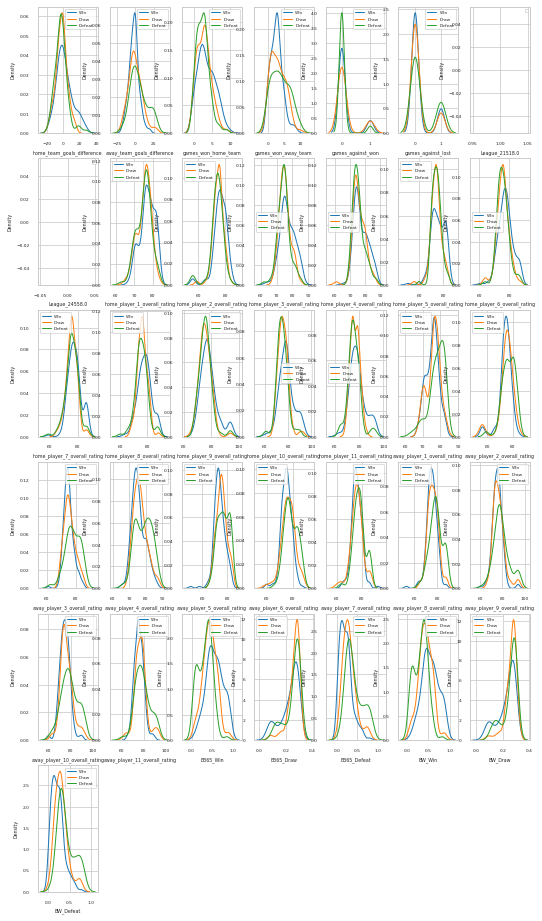

Win       0.481366
Defeat    0.279503
Draw      0.239130
Name: label, dtype: float64


In [9]:
# 데이터 탐색 및 시각화
labels = inputs.loc[:, 'label']    # 승/무/패
# print(labels)
features = inputs.drop('label', axis=1)
# print(features)
# features.head(5)
print(features.head(5))
feature_details = explore_data(features, inputs, path)

In [10]:
## Splitting the data into Train, Calibrate, and Test data sets
# test_size(float): represent the proportion of the dataset to include in the test split
# stratify: 지정된 label의 test_size 비율로 나누어짐
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size=0.3, random_state=42, stratify=y_train_calibrate)

## Creating cross validation data splits
# n_splits: Number of re-shuffling & splitting iterations 분리할 데이터셋의 개수
cv_sets = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=5)
cv_sets.get_n_splits(X_train, y_train)    # 분할 반복 횟수 반환

5

In [11]:
### Initializing all models and parameters

## Initializing classifiers

# n_estimators: The number of trees in the forest
# class_weight='balanced': y 값을 사용하여 n_samples / (n_classes*np.bincount(y))로 입력 데이터의 클래스 빈도에 반비례하는 가중치를 자동으로 조정 
RF_clf = RandomForestClassifier(n_estimators=200, random_state=1, class_weight='balanced')

# n_estimators: The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.
AB_clf = AdaBoostClassifier(n_estimators=200, random_state=2)

# Gaussian Naive Bayes
GNB_clf = GaussianNB()

# Classifier implementing the k-nearest neighbors vote
KNN_clf = KNeighborsClassifier()

# multi_class="ovr": 이진 문제 적용 시(?)
# solver="sag": 최적화 문제에 사용되는 알고리즘 중 하나
LOG_clf = linear_model.LogisticRegression(multi_class="ovr", solver="sag", class_weight='balanced')

clfs = [RF_clf, AB_clf, GNB_clf, KNN_clf, LOG_clf]


## Specifying scorer and parameters for grid search / grid search를 위한 scorer 및 parameter 지정

feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)    # cross_val_score에서 사용할 스코어링 함수 래핑


## 여기 dictionary에 정의된 key들은 함수 정의 시 사용되는 변수들인 듯. 함수 살피고 나서 역할 분석하면 될 듯.

parameters_RF = {'clf__max_features' : ['auto', 'log2'],
               'dm_reduce__n_components' : np.arange(5, feature_len, np.around(feature_len/5))}
parameters_AB = {'clf__learning_rate' : np.linspace(0.5, 2, 5), 
                'dm_reduce__n_components' : np.arange(5, feature_len, np.around(feature_len/5))}
parameters_GNB = {'dm_reduce__n_components' : np.arange(5, feature_len, np.around(feature_len/5))}
parameters_KNN = {'clf__n_neighbors' : [3, 5, 10],
                 'dm_reduce__n_components' : np.arange(5, feature_len, np.around(feature_len/5))}
parameters_LOG = {'clf__C' : np.logspace(1, 1000, 5),
                 'dm_reduce__n_components' : np.arange(5, feature_len, np.around(feature_len/5))}

parameters = {clfs[0]: parameters_RF,
             clfs[1]: parameters_AB,
             clfs[2]: parameters_GNB,
             clfs[3]: parameters_KNN,
             clfs[4]: parameters_LOG}

## Initializing dimensionality reductions / 차원 축소 초기화
## 뭐하는 얘들이지?
pca = PCA()
dm_reductions = [pca]

In [12]:
## 베이스라인 모델(GBC, Gradient Boosting Classifiers) 학습 및 grid search를 통한 최적의 모델 찾기
## 아마 GBC 모델 기준으로 학습이 진행되는 형식인 듯?
clf = LOG_clf
clf.fit(X_train, y_train)

# accuracy_score: 분류 점수 측정
# cross_val_score에서 사용할 스코어링 함수 래핑
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test))))

Score of LogisticRegression for training set: 0.6089.
Score of LogisticRegression for test set: 0.5077.


In [13]:
def find_best_classifier(classifiers, dm_reductions, scorer, X_t, y_t, X_c, y_c, X_v, y_v, cv_sets, params, jobs):
    ''' 모든 classifier 및 dimensionality reduction combinations를 통해 최상의 classifier 찾기 '''
    
    # Initialize result storage
    clfs_return = []
    dm_reduce_return = []
    train_scores = []
    test_scores = []
    
    # Loop through dimensionality reductions(???)
    for dm in dm_reductions:
        
        # Loop through classifiers
        for clf in clfs:
            
            # Grid search, calibrate, and test the classifier
            clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = clf, dm_reduction = dm, X_train = X_t, y_train = y_t,
                                                                             X_calibrate = X_c, y_calibrate = y_c, 
                                                                             X_test = X_v, y_test = y_v, cv_sets = cv_sets,
                                                                             params = params[clf], scorer = scorer, jobs = jobs, use_grid_search = True)
            
            # Append the result to storage
            clfs_return.append(clf)
            dm_reduce_return.append(dm_reduce)
            train_scores.append(train_score)
            test_scores.append(test_score)
            
    # Return storage        
    return clfs_return, dm_reduce_return, train_scores, test_scores


def train_calibrate_predict(clf, dm_reduction, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, params, scorer, jobs,
                           use_grid_search = True, **kwargs):
    ''' Train and predict using a classifier based on scorer. '''
    
    ## 분류기와 훈련 세트 사이즈 출력
    print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))
    
    ## Train the classifier
    best_pipe = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)
    
    ## Calibrate classifier
    print("Calibrating probabilities of classifier...")
    start = time()
    
    ##  CalibratedClassifierCV: isotonic 회귀 또는 로지스틱 회귀를 사용한 확률 보정
    # named_steps['clf']: 'clf'라는 명칭으로 단계에 진입(?)
    # cv='prefit': base_estimator가 이미 적합하고 모든 데이터가 보정에 사용되는 것으로 가정
    # method='isotonic': 검증에 사용할 방법 중 하나. isotonic: non-parametric approach
    clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv='prefit', method='isotonic')
    
    # transform(): 데이터를 변환하고 최종 분류기로 변환을 적용(??) 
    clf.fit(best_pipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)
    end = time()
    print("Callibrated {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    # Print the results of prediction for both training and testing
    print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_train, y_train)))
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_test, y_test)))
    
    # Return classifier, dm reduction, and label predictions for train and test set
    return clf, best_pipe.named_steps['dm_reduce'], predict_labels(clf, best_pipe, X_train, y_train), predict_labels(clf, best_pipe, X_test, y_test)
    
    

def train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs, use_grid_search = True, best_components = None, best_params = None):
    
    ''' Fits a classifier to the training data. '''

    # Start the clock, train the classifier, then stop the clock
    start = time()
    
    # Check if grid search should be applied
    if use_grid_search == True:
        
        # Define pipeline of dm reduction(dimensionality reduction) and classifier
        estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
        
        # sklearn.Pipeline: 최종 추정기를 사용한 변환 파이프라인
        # 파이프라인 사용 이점 https://rk1993.tistory.com/entry/Python-sklearnpipeline-%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8Pipeline%EC%9D%B4%EB%9E%80
        pipeline = Pipeline(estimators)    
    
        # 자료형이 float여서 생기는 문제 해결
        params['dm_reduce__n_components'] = params['dm_reduce__n_components'].astype(int)
    
        # Grid search over pipeline and return best classifier
        grid_obj = model_selection.GridSearchCV(pipeline, param_grid=params, scoring=scorer, cv=cv_sets, n_jobs=jobs)    # grid search 함수
        grid_obj.fit(X_train, y_train)
        best_pipe = grid_obj.best_estimator_    # best_estimator_: 가장 높은 점수를 제공한 모델
        
    else:
        
        # Use best components that are known without grid search
        estimators = [('dm_reduce', dm_reduction(n_components=best_components)), ('clf', clf(best_params))]
        pipeline = Pipeline(estimators)
        best_pipe = pipeline.fit(X_train, y_train)
        
    end = time()
    
    # Print the results
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start) / 60))
    
    # Return best pipe
    return best_pipe


def predict_labels(clf, best_pipe, features, target):
    ''' Makes predictions using a fit classifier based on scorer. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(best_pipe.named_steps['dm_reduce'].transform(features))
    end = time()
    
    # Print and return results
    print("Made predictions in {:.4f} seconds".format(end-start))
    
    return accuracy_score(target.values, y_pred)
        
        

In [14]:
## 모든 분류기를 학습시키고 비교
# clfs: 앞에서 정의한 5개 모델
# dm_reductions: pca(???)
# scorer: cross_val_score에서 사용할 스코어링 함수 래핑
# cv_sets: 교차 검증 객체
# parameters: parameter 지정 시 사용되는 변수들이 정의된 변수
# n_jobs: 이건 정확히 뭘까?
clfs, dm_reductions, train_scores, test_scores = find_best_classifier(clfs, dm_reductions, scorer, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, parameters, n_jobs)

Training a RandomForestClassifier with PCA...
Trained RandomForestClassifier in 0.3 minutes
Calibrating probabilities of classifier...
Callibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.0230 seconds
Score of CalibratedClassifierCV for training set: 0.9106.
Made predictions in 0.0201 seconds
Score of CalibratedClassifierCV for test set: 0.5077.
Made predictions in 0.0234 seconds
Made predictions in 0.0200 seconds
Training a AdaBoostClassifier with PCA...
Trained AdaBoostClassifier in 0.8 minutes
Calibrating probabilities of classifier...
Callibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.0331 seconds
Score of CalibratedClassifierCV for training set: 0.6034.
Made predictions in 0.0283 seconds
Score of CalibratedClassifierCV for test set: 0.5385.
Made predictions in 0.0335 seconds
Made predictions in 0.0275 seconds
Training a GaussianNB with PCA...
Trained GaussianNB in 0.0 minutes
Calibrating probabilities of classifier...
Callibrated CalibratedC

In [15]:
print(train_scores)

[0.9106145251396648, 0.6033519553072626, 0.5642458100558659, 0.5754189944134078, 0.5418994413407822]


In [16]:
def plot_training_results(clfs, dm_reductions, train_scores, test_scores, path):
    ''' Plot results of classifier training. '''
    
    ## Set graph format
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale = 1, rc={"lines.linewidth": 1})
    ax = plt.subplot(111)
    w = 0
    x = np.arange(len(train_scores))
    ax.set_yticks(x + w)    # y축의 눈금 위치를 설정
    ax.legend((train_scores[0], test_scores[0]), ("Train Scores", "Test Scores"))
    names = []
    
    ## Loop throuugh classifiers
    for i in range(0, len(clfs)): 
        
        # Define temporary variables        
        clf = clfs[i]
        clf_name = clf.base_estimator.__class__.__name__
        dm = dm_reductions[i]
        dm_name = dm.__class__.__name__
        
        #Create and store name
        name = "{} with {}".format(clf_name, dm_name)
        names.append(name)
        
    ## Plot all names in horizontal bar plot
    ax.set_yticklabels((names))
    plt.xlim(0.5, 0.55)
    plt.barh(x, test_scores, color = 'b', alpha = 0.6)
    plt.title("Test Data Accuracy Scores")
    fig = plt.figure(1)
    
    plt.show()

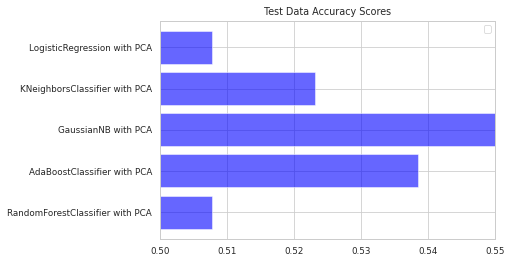

In [17]:
#Plotting train and test scores
plot_training_results(clfs, dm_reductions, np.array(train_scores), np.array(test_scores), path=path)

In [18]:
def plot_confusion_matrix(y_test, X_test, clf, dim_reduce, path, cmap=plt.cm.Blues, normalize = False):    
    ''' Plot confusion matrix for given classifier and data. '''
    
    #Define label names and get confusion matrix values
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, clf.predict(dim_reduce.transform(X_test)), labels)
    
    #Check if matrix should be normalized
    if normalize == True:
        
        #Normalize
        cm = cm.astype('float') / cm.sum()
        
    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title= "Confusion matrix of a {} with {}".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__)   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report
    y_pred = clf.predict(dim_reduce.transform(X_test))
    print(classification_report(y_test, y_pred)) 

The best classifier is a GaussianNB with PCA.


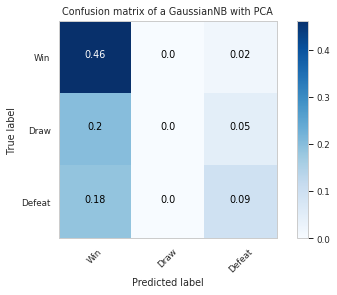

              precision    recall  f1-score   support

      Defeat       0.60      0.33      0.43        18
        Draw       0.00      0.00      0.00        16
         Win       0.55      0.97      0.70        31

    accuracy                           0.55        65
   macro avg       0.38      0.43      0.38        65
weighted avg       0.43      0.55      0.45        65



In [19]:
## Plotting a confusion matrix of the best model and the bookkeeper predictions
#Defining the best classifier and plotting a confusion matrix
best_clf = clfs[np.argmax(test_scores)]
best_dm_reduce = dm_reductions[np.argmax(test_scores)]
print("The best classifier is a {} with {}.".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__))
plot_confusion_matrix(y_test, X_test, best_clf, best_dm_reduce, path = path, normalize = True)

In [20]:
def plot_bookkeeper_cf_matrix(matches, bookkeepers, path, verbose=False, normalize=True):
    
    ''' Plot confusion matrix of bookkeeper predictions. '''
    
    if verbose==True: print("Obtaining labels...")
        
    # Get match labels
    y_test_temp = matches.apply(get_match_label, axis=1)
#     print(y_test_temp)
    
    if verbose==True: print("Obtaining bookkeeper probabilities...")
        
    # Get bookkeeper probabilities
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace=True, drop=True)    # 하나마나 차이 없는 것 같긴 한데 암튼...
    bookkeeper_probs.dropna(inplace=True)    # 결측값이 들어있는 행 전체 제거
    
    if verbose==True: print("Obtaining bookkeeper labels...")
        
    # Get bookkeeper labels
    y_pred_temp = pd.DataFrame()
    y_pred_temp.loc[:, 'bk_label'] = bookkeeper_probs[['Win', 'Draw', 'Defeat']].idxmax(axis=1)    # 세 레이블 중 최댓값을 가진 녀석을 값으로 채택
#     print(y_pred_temp)
    y_pred_temp.loc[:, 'match_api_id'] = bookkeeper_probs.loc[:, 'match_api_id']
#     print(y_pred_temp)
    
    if verbose==True: print("Plotting confusion matrix...")
        
    # Format data
    results = pd.merge(y_pred_temp, y_test_temp, on='match_api_id', how='left')
#     print(results)
    y_test = results.loc[:, 'label']
    y_pred = results.loc[:, 'bk_label']
    
    # Generate confusion matrix
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, y_pred, labels)
    
    # Check for normalization
    if normalize == True:
        cm = cm.astype('float') / cm.sum()
        
    # Plot confusion matrix
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title = "Confusion matrix of Bookkeeper predictions!"   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report and accuracy score of bookkeepers
    print(classification_report(y_test, y_pred)) 
    print("Bookkeeper score for test set: {:.4f}.".format(accuracy_score(y_test, y_pred)))



def get_bookkeeper_probs(matches, bookkeepers, horizontal=False):
    
    ''' Get bookkeeper data and convert to probabilities for vertical aggregation. '''
    ''' bookkeeper 데이터 가져와 수직 집계에 대한 확률로 전환(?) '''
    
    # Get bookkeeper data
    data = get_bookkeeper_data(matches, bookkeepers, horizontal=False)
    
    # Convert odds to probabilities 배당률을 확률로 바꾸기
    probs = convert_odds_to_prob(data)
    
    # Return data
    return probs

Obtaining labels...
Obtaining bookkeeper probabilities...
Obtaining bookkeeper labels...
Plotting confusion matrix...


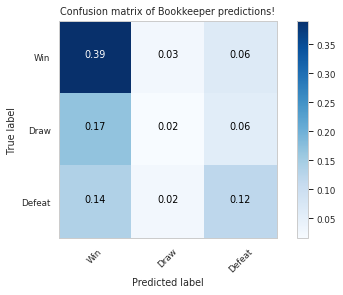

              precision    recall  f1-score   support

      Defeat       0.50      0.43      0.46       630
        Draw       0.23      0.06      0.10       539
         Win       0.56      0.81      0.67      1085

    accuracy                           0.53      2254
   macro avg       0.43      0.43      0.41      2254
weighted avg       0.47      0.53      0.47      2254

Bookkeeper score for test set: 0.5262.


In [21]:
# Plotting a confusion matrix of bookkeepers
plot_bookkeeper_cf_matrix(match_data, bk_cols, path, verbose=True, normalize=True)

In [22]:
def optimize_betting(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, match_data, fifa_data,
                     n_samples, sample_size, parameter_1_grid, parameter_2_grid, verbose = False):
    
    ''' Tune parameters of bet selection algorithm. '''
    
    # Generate data samples
    samples = []
    
    for i in range(0, n_samples):
        sample = match_data.sample(n=sample_size, random_state=42)
        samples.append(sample)

    results = pd.DataFrame(columns = ["parameter_1", "parameter_2", "results"])
    row = 0
    
    # Iterate over all 1 parameter 1개의 모든 매개변수(?)에 대해 반복
    for i in parameter_1_grid:
        
        # Iterate over all 2 parameter
        for j in parameter_2_grid:
            
            # Compute average score over all samples
            profits = []
            for sample in samples:
                # print(sample)
                choices = find_good_bets(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, sample, fifa_data, i, j)
                profit = execute_bets(choices, match_data)
                profits.append(profit)
            result = np.mean(np.array(profits))
            results.loc[row, "results"] = result
            results.loc[row, "parameter_1"]
            results.loc[row,"parameter_2"] = j
            row = row + 1
            if verbose == True: print("Simulated parameter combination: {}".format(row))
               
    #Return best setting and result
    best_result = results.loc[results['results'].idxmax()] 
    return best_result
            
            
def find_good_bets(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, percentile, prob_cap, verbose = False):
    ''' Find good bets for a given classifier and matches. '''
    
    #Compare model and classifier probabilities
    probs = compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False)
    probs.loc[:, 'prob_difference'] = probs.loc[:,"model_prob"] - probs.loc[:,"bookkeeper_prob"]
    
    #Sort by createst difference to identify most underestimated bets    
    values = probs['prob_difference']
    values = values.sort_values(ascending = False)
    values.reset_index(inplace = True, drop = True)
    
    if verbose == True:
        print("Selecting attractive bets...")
        
    #Identify choices that fulfill requirements such as positive difference, minimum probability and match outcome
    relevant_choices = probs[(probs.prob_difference > 0) & (probs.model_prob > prob_cap) & (probs.bet != "Draw")]
    
    #Select given percentile of relevant choices    
    top_percent = 1 - percentile
    choices = relevant_choices[relevant_choices.prob_difference >= relevant_choices.prob_difference.quantile(top_percent)]
    choices.reset_index(inplace = True, drop = True)
    
    #Return choices
    return choices


def compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False):
    ''' Map bookkeeper and model probabilities. '''
    
    #Create features and labels for given matches
    feables = create_feables(matches, fifa_data, bk, get_overall = True, verbose = False)
    
    #Ensure consistency
    match_ids = list(feables['match_api_id'])
    matches = matches[matches['match_api_id'].isin(match_ids)]
    
    #Get bookkeeper probabilities
    if verbose == True:
        print("Obtaining bookkeeper probabilities...")
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    
    inputs = feables.drop('match_api_id', axis = 1)
    labels = inputs.loc[:,'label']
    features = inputs.drop('label', axis = 1)
    
    #Get model probabilities
    if verbose == True:
        print("Predicting probabilities based on model...")
    model_probs = pd.DataFrame()
    label_table = pd.Series()
    temp_probs = pd.DataFrame(clf.predict_proba(dim_reduce.transform(features)), columns = ['win_prob', 'draw_prob', 'defeat_prob'])
    for bookkeeper in bookkeepers:
        model_probs = model_probs.append(temp_probs, ignore_index = True)
        label_table = label_table.append(labels)
    model_probs.reset_index(inplace = True, drop = True)
    label_table.reset_index(inplace = True, drop = True)
    bookkeeper_probs['win_prob'] = model_probs['win_prob']
    bookkeeper_probs['draw_prob'] = model_probs['draw_prob']
    bookkeeper_probs['defeat_prob'] = model_probs['defeat_prob']
    bookkeeper_probs['label'] = label_table 
    
    #Aggregate win probabilities for each match
    wins = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Win', 'win_prob', 'label']]
    wins.loc[:, 'bet'] = 'Win'
    wins = wins.rename(columns = {'Win':'bookkeeper_prob',
                                  'win_prob': 'model_prob'})
                                  
    #Aggregate draw probabilities for each match
    draws = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Draw', 'draw_prob', 'label']]
    draws.loc[:, 'bet'] = 'Draw'
    draws = draws.rename(columns = {'Draw':'bookkeeper_prob',
                                  'draw_prob': 'model_prob'})
                                  
    #Aggregate defeat probabilities for each match
    defeats = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Defeat', 'defeat_prob', 'label']]
    defeats.loc[:, 'bet'] = 'Defeat'
    defeats = defeats.rename(columns = {'Defeat':'bookkeeper_prob',
                                  'defeat_prob': 'model_prob'})
    
    total = pd.concat([wins, draws, defeats])
    
    #Return total
    return total

def execute_bets(bet_choices, matches, verbose = False):
    ''' Get rewards for all bets. '''    
    
    if verbose == True:
        print("Obtaining reward for chosen bets...")
    total_reward = 0
    total_invested = 0
    
    #Loop through bets
    loops = np.arange(0, bet_choices.shape[0])     
    for i in loops:
        
        #Get rewards and accumulate profit
        reward = get_reward(bet_choices.iloc[i,:], matches)
        total_reward = total_reward + reward
        total_invested += 1
    
    #Compute investment return
    investment_return = float(total_reward / total_invested) - 1
    
    #Return investment return
    return investment_return


def get_reward(choice, matches):
    ''' Get the reward of a given bet. '''
    
    #Identify bet
    match = matches[matches.match_api_id == choice.match_api_id]
    bet_data = match.loc[:,(match.columns.str.contains(choice.bookkeeper))]
    cols = bet_data.columns.values
    cols[:3] = ['win','draw','defeat']
    bet_data.columns = cols
    
    #Identfiy bet type and get quota
    if choice.bet == 'Win':
        bet_quota = bet_data.win.values
    elif choice.bet == 'Draw':
        bet_quota = bet_data.draw.values
    elif choice.bet == 'Defeat':
        bet_quota = bet_data.defeat.values
    else:
        print("Error")
    
    #Check label and compute reward
    if choice.bet == choice.label:
        reward = bet_quota
    else:
        reward = 0
    
    #Return reward
    return reward

In [23]:
# ## Running a grid search to find the best betting strategy based on the prediction model
# #Finding best betting strategy and profit
# percentile_grid = np.linspace(0, 1, 2)
# probability_grid = np.linspace(0, 0.5, 2)
# best_betting = optimize_betting(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, match_data, fifa_data,
#                      5, 300, percentile_grid, probability_grid, verbose = True)
# end = time()    
# print("Program run in {:.1f} minutes".format((end - start)/60))
# print("The best return of investment is: {}".format(best_betting.results))